In [127]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse import csr_matrix
from datetime import datetime
import os
import random
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset

In [64]:
rating = pd.read_csv("./data/ratings.csv")
movie = pd.read_csv("./data/movies.csv")
rating.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [65]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## 1. The genres are separated by '|' , so let try to get a one-hot-encoded version of it

In [66]:
dummy = movie['genres'].str.get_dummies(sep='|')
dummy.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 1.1 The Movie dataframe with all the genres

In [67]:
movie = pd.merge(movie, dummy, left_index=True, right_index=True)
movie.drop(['genres'], axis=1, inplace=True)
movie.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2 We might need the years of the movie for the Content Based Recommendation

In [68]:
movie['year'] = [title[-5:-1] for title in movie['title']]
movie['title'] = [title[:-7] for title in movie['title']]
movie.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [69]:
year = movie.pop('year')
movie.insert(2, 'year', year)
movie.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 1.3 Basic Statistics Check

In [70]:
print(len(movie),len(np.unique(movie['movieId'])))

10329 10329


#### Hence All id's are unique

In [71]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
userId       105339 non-null int64
movieId      105339 non-null int64
rating       105339 non-null float64
timestamp    105339 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [72]:
print("Unique UserId are: ", len(np.unique(rating['userId'])))
print("Unique movieId are: ", len(np.unique(rating['movieId'])))

Unique UserId are:  668
Unique movieId are:  10325


#### So we don't have ratings for 4 movies

### 1.4 Let create a movie-user rating matrix

In [73]:
m_u_matrix = rating.pivot_table(index='movieId', columns='userId', values='rating')
m_u_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0
3,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5


In [74]:
m_u_matrix.fillna(0, inplace=True)
m_u_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


In [94]:
rating.shape

(105339, 4)

## 2. Applying Basic EDA to better understand the Data

### 2.1 Distribution of the Movie Ratings

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


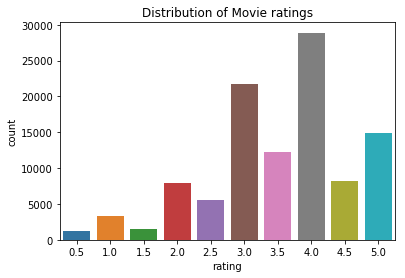

In [75]:
plt.title("Distribution of Movie ratings")
sns.countplot(rating['rating'])
plt.show()

### 2.2 Ratings per User

In [76]:
rating_per_user = rating.groupby('userId')['rating'].agg('count')
rating_per_user.sort_values(ascending=False)[:5]

userId
668    5678
575    2837
458    2086
232    1421
310    1287
Name: rating, dtype: int64

#### A User giving more than 1k or 2k reviews is quite absurd, let's dig deep

In [77]:
def getPDFCDF(lst, name):
    ax1 = plt.subplot(121)
    plt.title("PDF")
    sns.kdeplot(lst, shade=True, ax=ax1)
    plt.xlabel("Ratings per "+ name)

    ax2 = plt.subplot(122)
    plt.title("CDF")
    sns.kdeplot(lst, cumulative=True, shade=True, ax=ax2)
    plt.xlabel("Ratings per " + name)

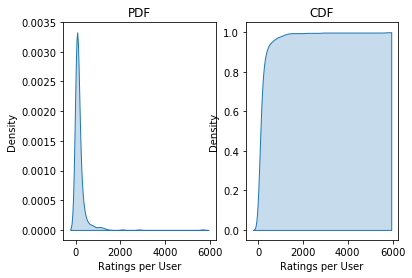

In [78]:
getPDFCDF(rating_per_user, "User")

#### The CDF both suggests that almost 95% of the users have given less than 1k reviews which is normal

### 2.3 Ratings per Movie

In [79]:
rating_per_movie = rating.groupby('movieId')['rating'].count().sort_values(ascending=False)
rating_per_movie[:5]

movieId
296    325
356    311
318    308
480    294
593    290
Name: rating, dtype: int64

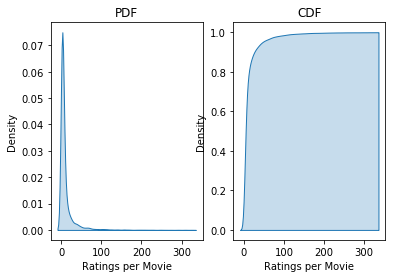

In [80]:
getPDFCDF(rating_per_movie, "Movie")

#### Very Few movies got more than 100 reviews

# Collaborative Filtering based Recommendation

### 3. Creating the Sparse Matrix

In [81]:
start = datetime.now()
if os.path.isfile('sparse_matrix.npz'):
    print("Matrix already prsent...being loaded")
    print("The shape of sparse matrix is :", sparse_matrix.shape)

    sparse_matrix = sparse.load_npz('sparse_matrix.npz')
else:
    sparse_matrix = sparse.csr_matrix(m_u_matrix.values)
    sparse.save_npz('sparse_matrix.npz', sparse_matrix)
    print("The shape of sparse matrix is :", sparse_matrix.shape)

print("Time Taken: ", datetime.now() - start)

Matrix already prsent...being loaded
The shape of sparse matrix is : (10325, 668)
Time Taken:  0:00:00.013923


In [82]:
m_u_matrix.reset_index(inplace=True)
m_u_matrix.head()

userId,movieId,1,2,3,4,5,6,7,8,9,...,659,660,661,662,663,664,665,666,667,668
0,1,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,...,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


In [83]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [84]:
movieList = movie[movie['title'].str.contains("Toy Story 2")]
movieList

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2496,3114,Toy Story 2,1999,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## 3.1 KNN Based Recommendation

In [85]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movie[movie['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = m_u_matrix[m_u_matrix['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(sparse_matrix[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = m_u_matrix.iloc[val[0]]['movieId']
            idx = movie[movie['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movie.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df['Title']
    else:
        print("No movies found. Please check your input")
        return

In [86]:
movie_name = random.choice(movie['title'].unique())
print("The Top 10 Recommendation for the Movie {} are: ".format(movie_name.upper()))
get_movie_recommendation(movie_name)

The Top 10 Recommendation for the Movie BUTCHER BOY, THE are: 


1          Big Bounce, The
2                Black Sea
3           Duellists, The
4            Stranger, The
5                 Child 44
6     End of Violence, The
7      The Left Handed Gun
8          Cat's Meow, The
9             Viva Zapata!
10          At Close Range
Name: Title, dtype: object

### 4. Using Surprise Libarary

In [87]:
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import SVD, NMF, KNNBaseline, SVDpp, NMF
from surprise.model_selection import cross_validate

### 4.1 Getting a Datetime column that will help us to split the data into train and test

In [88]:
rating['datetime'] = pd.to_datetime(rating['timestamp'],unit='s')
rating['datetime'] = rating['datetime'].dt.strftime('%Y-%m-%d')
rating['datetime'] = pd.to_datetime(rating['datetime'])
rating = rating.drop('timestamp', axis=1)
rating.head()

,userId,movieId,rating,datetime
0,1,16,4.0,2008-08-05
1,1,24,1.5,2008-08-05
2,1,32,4.0,2008-08-05
3,1,47,4.0,2008-08-05
4,1,50,4.0,2008-08-05


In [89]:
rating.sort_values(by='datetime', inplace=True)
rating.head()

,userId,movieId,rating,datetime
44833,312,380,4.0,1996-04-03
44799,312,54,3.0,1996-04-03
44798,312,48,4.0,1996-04-03
44797,312,47,4.0,1996-04-03
44820,312,277,4.0,1996-04-03


### 4.2 Splitting into train and test

In [90]:
if not os.path.isfile("train.csv"):
    rating.iloc[:int((rating.shape[0]*0.8))].to_csv("train.csv", index=False)
else:
    print("train file exists...")
if not os.path.isfile("test.csv"):
    rating.iloc[int((rating.shape[0])*0.8):].to_csv("test.csv", index=False)
else:
    print("test file exists...")
    
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


train file exists...
test file exists...


In [91]:
train_df = train_df.drop(['datetime'], axis=1)
test_df = test_df.drop(['datetime'], axis=1)
train_df.head()

,userId,movieId,rating
0,312,380,4.0
1,312,54,3.0
2,312,48,4.0
3,312,47,4.0
4,312,277,4.0


In [92]:
train_df.shape

(84271, 3)

In [101]:
train_matrix = train_df.pivot_table(index='userId', columns='movieId', values='rating')


In [102]:
train_matrix.fillna(0, inplace=True)

In [103]:
test_matrix = test_df.pivot_table(index='userId', columns='movieId', values='rating')


In [104]:
test_matrix.fillna(0, inplace=True)

In [105]:
test_matrix.head()

movieId,1,2,5,6,7,9,10,11,12,13,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
def createSparse(df, name):
    start = datetime.now()
    if os.path.isfile(name+'_sparse_matrix.npz'):
        print("It is present in your pwd, getting it from disk....")
        if name=='train':
            train_sparse_matrix = sparse.load_npz(name+'_sparse_matrix.npz')
        else:
            test_sparse_matrix = sparse.load_npz(name+'_sparse_matrix.npz')
            
        print("DONE..")
    else: 
        print("We are creating sparse_matrix from the dataframe..")
        # create sparse_matrix and store it for after usage.
        # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
        # It should be in such a way that, MATRIX[row, col] = data
        if name=='train':
            train_sparse_matrix = sparse.csr_matrix(df)
            print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
            print('Saving it into disk for furthur usage..')
            sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
        else:
            test_sparse_matrix = sparse.csr_matrix(df)
            print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
            print('Saving it into disk for furthur usage..')
            sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

        
        print('Done..\n')

    print(datetime.now() - start)
    if name=='train':
        return train_sparse_matrix
    else:
        return test_sparse_matrix

In [115]:
train_sparse_matrix = createSparse(train_matrix, 'train')

It is present in your pwd, getting it from disk....
DONE..
0:00:00.011968


In [116]:
test_sparse_matrix = createSparse(test_matrix, 'test')

It is present in your pwd, getting it from disk....
DONE..
0:00:00.007946


### 4.3 Function for getting Average rating per User/Movie

In [117]:
def get_average_rating(sparse_matrix, is_users):
    if is_users:
        ax = 1
    else:
        ax = 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1 #A1 converts to 1D array
    #sum_of_ratings returns an 1D array with total_ratings of Users/ Movies, if there are 668 Users(and we say axis=1) it returns an array of length 668 each with a sum value
    is_rated = sparse_matrix != 0 #Creates a boolean matrix
    no_of_ratings = is_rated.sum(axis=ax).A1
    avg_ratings = {}
    u, m = sparse_matrix.shape
    for i in range(u if is_users else m):
        if no_of_ratings[i]!= 0:
            avg_ratings[i] = sum_of_ratings[i] / no_of_ratings[i]
    return avg_ratings


In [134]:
train_averages = {}
train_averages['users'] = get_average_rating(train_sparse_matrix, True) #"users" key contain a dictionary with each users as key there an d their avg ratings as values

train_averages['movies'] = get_average_rating(train_sparse_matrix, False)
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = global_average


In [137]:
train_averages['global']

3.4897414294359863

In [135]:
test_averages = {}
test_averages['users'] = get_average_rating(test_sparse_matrix, True) #"users" key contain a dictionary with each users as key there an d their avg ratings as values

test_averages['movies'] = get_average_rating(test_sparse_matrix, False)
global_average = test_sparse_matrix.sum()/test_sparse_matrix.count_nonzero()
test_averages['global'] = global_average

In [136]:
test_averages['global']

3.6252847921017657

### PDF & CDF of average ratings

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an 

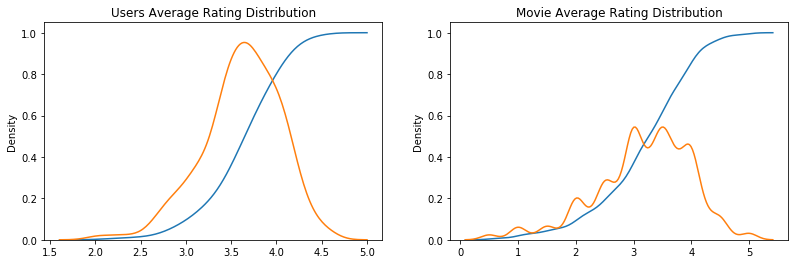

In [121]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = plt.figaspect(0.3))

ax1.set_title("Users Average Rating Distribution")
users_avg_rating = [rating for rating in train_averages['users'].values()]
sns.distplot(users_avg_rating, ax=ax1, hist=False, kde_kws =dict(cumulative=True), label='CDF')
sns.distplot(users_avg_rating, ax=ax1, hist=False, label='PDF')


ax2.set_title("Movie Average Rating Distribution")
movies_avg_rating = [rating for rating in train_averages['movies'].values()]
sns.distplot(movies_avg_rating, ax=ax2, hist=False, kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(movies_avg_rating, hist=False, label='PDF')

In [126]:
train_users, train_movies, train_ratings = sparse.find(train_sparse_matrix)

### Featurising the Train Data

In [128]:
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(train_users, train_movies, train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['movies'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_averages['users'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_averages['users'][user])
            # Avg_movie rating
            row.append(train_averages['movies'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 84271 tuples for the dataset..

Done for 10000 rows----- 0:01:19.306387
Done for 20000 rows----- 0:02:32.596084
Done for 30000 rows----- 0:03:48.220597
Done for 40000 rows----- 0:05:03.485211
Done for 50000 rows----- 0:06:13.196900
Done for 60000 rows----- 0:07:32.017927
Done for 70000 rows----- 0:08:46.844721
Done for 80000 rows----- 0:10:09.508243
0:10:40.027842


In [129]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1,0,3.489741,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.896552,3.909326,5.0
1,4,0,3.489741,5.0,5.0,4.0,3.0,5.0,4.0,5.0,4.0,5.0,3.0,3.796610,3.909326,5.0
2,6,0,3.489741,4.0,4.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,5.0,3.525773,3.909326,4.0
3,9,0,3.489741,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,3.0,5.0,3.476190,3.909326,4.0
4,19,0,3.489741,4.0,3.0,4.0,3.0,5.0,5.0,3.0,5.0,5.0,4.0,3.525926,3.909326,3.0


In [138]:
test_users, test_movies, test_ratings = sparse.find(test_sparse_matrix)

In [139]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T,train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([train_averages['users'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(train_averages['users'][user])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(train_averages['movies'][movie])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 21068 tuples for the dataset..

Done for 1000 rows----- 0:00:06.820771
Done for 2000 rows----- 0:00:13.632498
Done for 3000 rows----- 0:00:20.124567
Done for 4000 rows----- 0:00:26.608892
Done for 5000 rows----- 0:00:33.264710
Done for 6000 rows----- 0:00:40.170002
Done for 7000 rows----- 0:00:46.978565
Done for 8000 rows----- 0:00:53.510483
Done for 9000 rows----- 0:00:59.951334
Done for 10000 rows----- 0:01:06.616172
Done for 11000 rows----- 0:01:13.312145
Done for 12000 rows----- 0:01:20.430279
Done for 13000 rows----- 0:01:27.785427
Done for 14000 rows----- 0:01:34.696597
Done for 15000 rows----- 0:01:41.295934
Done for 16000 rows----- 0:01:47.547870
Done for 17000 rows----- 0:01:54.002640
Done for 18000 rows----- 0:02:00.401664
Done for 19000 rows----- 0:02:06.976020
Done for 20000 rows----- 0:02:12.807787
Done for 21000 rows----- 0:02:18.437061
 0:02:18.842128


In [140]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,0,0,3.489741,3.0,3.0,3.5,4.5,4.0,4.5,4.5,4.0,3.5,3.0,3.628319,3.909326,4.0
1,5,0,3.489741,4.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,2.702479,3.909326,5.0
2,10,0,3.489741,4.0,4.0,3.0,5.0,4.0,5.0,5.0,4.0,4.0,4.0,4.024691,3.909326,5.0
3,13,0,3.489741,5.0,4.5,4.5,5.0,4.0,4.0,3.5,1.5,4.0,4.0,3.421569,3.909326,3.0


### Building data for Surprise

In [141]:
reader = Reader(rating_scale=(0,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [144]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[-3:]

[(135, 5493, 4.5), (156, 5493, 4.5), (108, 5494, 4.0)]

### Applying ML Models

In [145]:
models_evaluation_train = dict()
models_evaluation_test = dict()

In [146]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


In [147]:
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    train_results = dict()
    test_results = dict()

    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

In [149]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

In [150]:
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [151]:
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

In [154]:
import xgboost as xgb

Training the model..


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[16:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Done. Time taken : 0:00:08.813485

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.5477199502478356
MAPE :  42.36955235730439


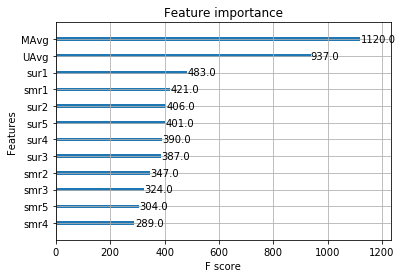

In [155]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

In [156]:
from surprise import BaselineOnly 

In [157]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:03.480049 

Evaluating the model with train data..
time taken : 0:00:16.489465
---------------
Train Data
---------------
RMSE : 0.8767220924084861

MAPE : 30.346533717279666

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.359550
---------------
Test Data
---------------
RMSE : 1.0588570650377174

MAPE : 34.91353747317135

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:20.517730


In [158]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1,0,3.489741,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.896552,3.909326,5.0,4.031756
1,4,0,3.489741,5.0,5.0,4.0,3.0,5.0,4.0,5.0,4.0,5.0,3.0,3.796610,3.909326,5.0,3.465098


In [159]:
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,0,0,3.489741,3.0,3.0,3.5,4.5,4.0,4.5,4.5,4.0,3.5,3.0,3.628319,3.909326,4.0,3.803532
1,5,0,3.489741,4.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,2.702479,3.909326,5.0,3.150402


Training the model..


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[16:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Done. Time taken : 0:00:11.011644

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.5051782125765687
MAPE :  41.72990318077842


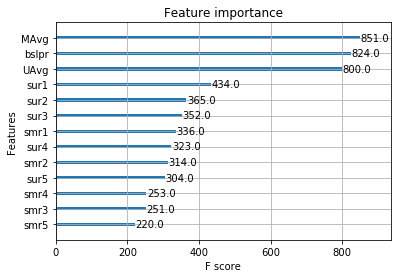

In [160]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

In [161]:
from surprise import KNNBaseline

### KNN Baseline with User-User similarity

In [162]:
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:02.199444 

Evaluating the model with train data..
time taken : 0:00:17.187741
---------------
Train Data
---------------
RMSE : 0.30402715093133437

MAPE : 8.255268659697359

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.611820
---------------
Test Data
---------------
RMSE : 1.3169902900855415

MAPE : 39.75027454501362

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:21.053339


### KNN Baseline with Movi Movie similarity

In [163]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:07:57.682549 

Evaluating the model with train data..
time taken : 0:03:59.660853
---------------
Train Data
---------------
RMSE : 0.31503760698532196

MAPE : 8.88791680908357

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:06.957157
---------------
Test Data
---------------
RMSE : 1.176918627800677

MAPE : 36.843527058463785

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:12:04.672776


### XGBoost + Baseline + KNN Baseline

In [165]:
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1,0,3.489741,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.896552,3.909326,5.0,4.031756,4.679489,4.795940
1,4,0,3.489741,5.0,5.0,4.0,3.0,5.0,4.0,5.0,4.0,5.0,3.0,3.796610,3.909326,5.0,3.465098,2.573728,2.473299


In [166]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,0,0,3.489741,3.0,3.0,3.5,4.5,4.0,4.5,4.5,4.0,3.5,3.0,3.628319,3.909326,4.0,3.803532,3.888854,3.750226
1,5,0,3.489741,4.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,2.702479,3.909326,5.0,3.150402,3.329796,3.261707


In [167]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

Training the model..


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Done. Time taken : 0:00:14.371759

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.480120355518577
MAPE :  41.31032225297566


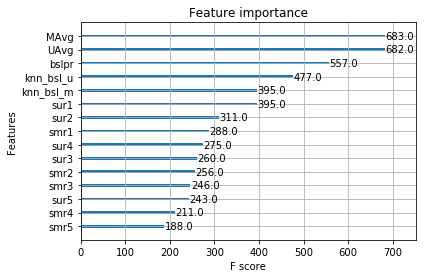

In [169]:
xgb.plot_importance(xgb_knn_bsl)
plt.show()

### SVD with User-Movie

In [168]:
from surprise import SVD

 __Optimization problem with user item interactions and regularization (to avoid overfitting)__


In [170]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:11.016868 

Evaluating the model with train data..
time taken : 0:00:02.196509
---------------
Train Data
---------------
RMSE : 0.6311023358382358

MAPE : 20.70470304231493

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.410324
---------------
Test Data
---------------
RMSE : 1.1367190095215383

MAPE : 36.17832772264363

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:13.757450


In [172]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']

In [173]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']

Training the model..


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Done. Time taken : 0:00:11.597330

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.4489747816046674
MAPE :  40.855700991893826


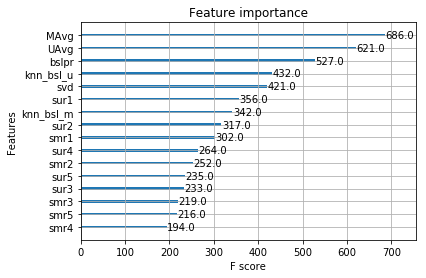

In [174]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h2> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h2>

Training the model..


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Done. Time taken : 0:00:08.088056

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0419226291829358
MAPE :  34.34881844965341


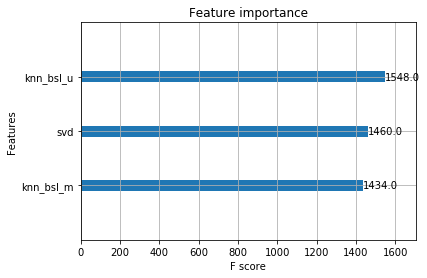

In [176]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [178]:
pd.DataFrame(models_evaluation_test).to_csv('results.csv')
models = pd.read_csv('results.csv', index_col=0)
models.loc['rmse'].sort_values()

xgb_all_models    1.0419226291829358
bsl_algo          1.0588570650377174
svd               1.1367190095215383
knn_bsl_m          1.176918627800677
knn_bsl_u         1.3169902900855415
xgb_final         1.4489747816046674
xgb_knn_bsl        1.480120355518577
xgb_bsl           1.5051782125765687
first_algo        1.5477199502478356
Name: rmse, dtype: object